In [1]:
import numpy as np
import pandas as pd #this might need to be installed
import datetime
import matplotlib.pyplot as plt
import statistics as sts
from scipy.optimize import minimize,least_squares
from sympy import symbols, diff
from sympy.functions import exp
from iminuit import Minuit
#import ROOT

    # "from fibertest_fncts import frdmunits,unpack_data,unpack_and_throw_outliers" Instead we do
frdmunits=2.54 #cm/inch
def unpack_data(datafile,npos,size):

    data_list=np.transpose(np.array(pd.read_csv(datafile)))

    points=int((len(data_list)-6)/2) # This is the number of data points taken
    #size is the number of data points we want to unpack
    newpmtstd=np.empty(npos)
    newpmtmean=np.empty(npos)
    newsipmstd=np.empty(npos)
    newsipmmean=np.empty(npos)

    npmtoutlier=0
    nsipmoutlier=0

    for i in range(npos):
        np.transpose(data_list)[i][2:-(2*points-size+4)]
        stdev_pmt=sts.stdev(np.transpose(data_list)[i][2:-(2*points-size+4)])
        avg_pmt=sts.mean(np.transpose(data_list)[i][2:-(2*points-size+4)])
        newpmtdata=[]

        np.transpose(data_list)[i][-(points+4):-(4+(points-size))]
        stdev_sipm=sts.stdev(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])
        avg_sipm=sts.mean(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])
        newsipmdata=[]


        for j in range(len(np.transpose(data_list)[i][2:-(points-size+4)])):
            if np.transpose(data_list)[i][j+2]<avg_pmt+2*stdev_pmt and np.transpose(data_list)[i][j+2]>avg_pmt-2*stdev_pmt:
                newpmtdata.append(np.transpose(data_list)[i][j+2])
                #print("good")
            else:
                npmtoutlier+=1

        for j in range(len(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])):
            if np.transpose(data_list)[i][j+points+2]<avg_sipm+2*stdev_sipm and np.transpose(data_list)[i][j+points+2]>avg_sipm-2*stdev_sipm:
                newsipmdata.append(np.transpose(data_list)[i][j+points+2])
                #print("good")
            else:
                nsipmoutlier+=1

        newpmtstd[i]=sts.stdev(newpmtdata)*10**6
        newpmtmean[i]=-sts.mean(newpmtdata)*10**6
        newsipmstd[i]=sts.stdev(newsipmdata)*10**6
        newsipmmean[i]=-sts.mean(newsipmdata)*10**6
        #print(size-len(newpmtdata))
    return np.array([newpmtmean,newpmtstd,newsipmmean,newsipmstd])
def unpack_and_throw_outliers(filename,runs,pos):
    pmt_mean_old=-np.transpose(np.array(pd.read_csv(filename)))[-4]*10**6
    pmt_std_old=np.transpose(np.array(pd.read_csv(filename)))[-3]*10**6
    pmt_data=np.transpose(np.array(pd.read_csv(filename)))[2:-(runs+4)]*10**6 # all data taken by the pmt per position
    sipm_data=np.transpose(np.array(pd.read_csv(filename)))[-(runs+4):-4]*10**6 # all data taken by the sipm per position
    
    pmt_data_no_outliers=[]
    sipm_data_no_outliers=[]
    pmt_data_no_outliers_means=[]
    pmt_data_no_outliers_std=[]
    for i in range(len(pos)):
        data=np.transpose(pmt_data)[i]
        det_data=np.transpose(sipm_data)[i]
        # Create a box plot
        box_props = plt.boxplot(data)
        
       # plt.show()

        # Get the whisker ranges
        lower_whisker = box_props['whiskers'][0].get_ydata()[1]
        upper_whisker = box_props['whiskers'][1].get_ydata()[1]

        # Identify outliers using IQR method
        iqr = upper_whisker - lower_whisker
        lower_bound = lower_whisker
        upper_bound = upper_whisker

        outliers = np.where((data < lower_bound) | (data > upper_bound))[0]
        #print(outliers,lower_bound,upper_bound)
    
         # Remove outliers from the data
        no_outlier_pmt_data = -np.delete(data, outliers)
        no_outlier_sipm_data = np.delete(det_data, outliers)
        
        pmt_data_no_outliers.append(no_outlier_pmt_data)
        sipm_data_no_outliers.append(no_outlier_sipm_data)

        pmt_data_no_outliers_means.append(np.mean(no_outlier_pmt_data))
        pmt_data_no_outliers_std.append(np.std(no_outlier_pmt_data))
    
    
    fig = plt.figure(figsize=(16, 10), dpi=80)
    # Error propagation formula for the ratio
    #err = (lsr_crctd_data_mean/pmt_mean_old) * np.sqrt((lsr_crctd_data_stdev / lsr_crctd_data_mean)**2 + (pmt_std_old / pmt_mean_old)**2)
    err = (pmt_data_no_outliers_std/pmt_mean_old)
    plt.errorbar(pos,pmt_data_no_outliers_means/pmt_mean_old,yerr=err, fmt="o", color="k",capsize=5,label='Ratio of corrected to raw data')
    #plt.errorbar(pos,pmt_mean_old, yerr=pmt_std_old, fmt="o", color="b",capsize=5,label='Fiber')
    plt.legend()
    plt.show()
    return         pmt_data_no_outliers, sipm_data_no_outliers, pmt_data_no_outliers_means, pmt_data_no_outliers_std

# Getting data from Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

x0=(1.5+2.75)*2.54 #cm/inch
UncutL=78.8 #(4+73.5)*2.54+x0 #cm/inch
RefurbL=78.7 #(4+73.5)*2.54+x0 #cm/inch 
L_err=0.125*frdmunits
pos=np.transpose(np.array(pd.read_csv("fibertest_007160.csv")))[0]*frdmunits+x0
pos_zero=np.concatenate((pos, [0.]))

#Fibers
uncut="fibertest_007181.csv"
cut="fibertest_000722.csv"
ref="fibertest_007221.csv"

In [2]:
pos

array([73.025  , 65.24625, 57.4675 , 49.68875, 41.91   , 34.13125,
       26.3525 , 18.57375, 10.795  ])

In [3]:
#Uncut
uncut_pmt_data=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[2:-104])
uncut_sipm_data=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-104:-4])
uncut_pmt_means=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-4])
uncut_pmt_std=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-3])
uncut_sipm_means=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-2])
uncut_sipm_std=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-1])

#Cut
cut_pmt_data=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[2:-104])
cut_sipm_data=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-104:-4])
cut_pmt_means=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-4])
cut_pmt_std=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-3])
cut_sipm_means=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-2])
cut_sipm_std=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-1])

#Refurb
ref_pmt_data=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[2:-104])
ref_sipm_data=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-104:-4])
ref_pmt_means=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-4])
ref_pmt_std=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-3])
ref_sipm_means=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-2])
ref_sipm_std=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-1])

uncut_pmt_means

array([-1.00115928e-05, -9.78041422e-06, -9.96769800e-06, -1.01721606e-05,
       -1.04023311e-05, -1.06174891e-05, -1.10136435e-05, -1.16244668e-05,
       -1.23249867e-05])

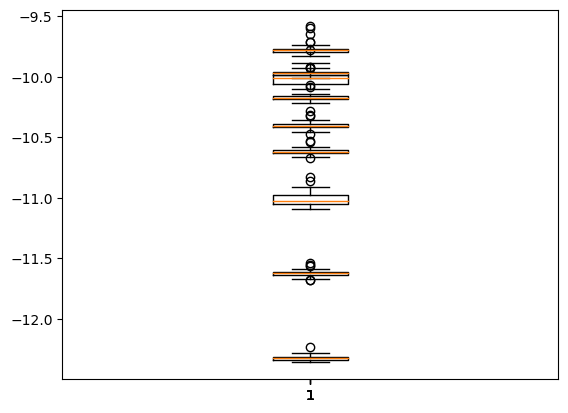

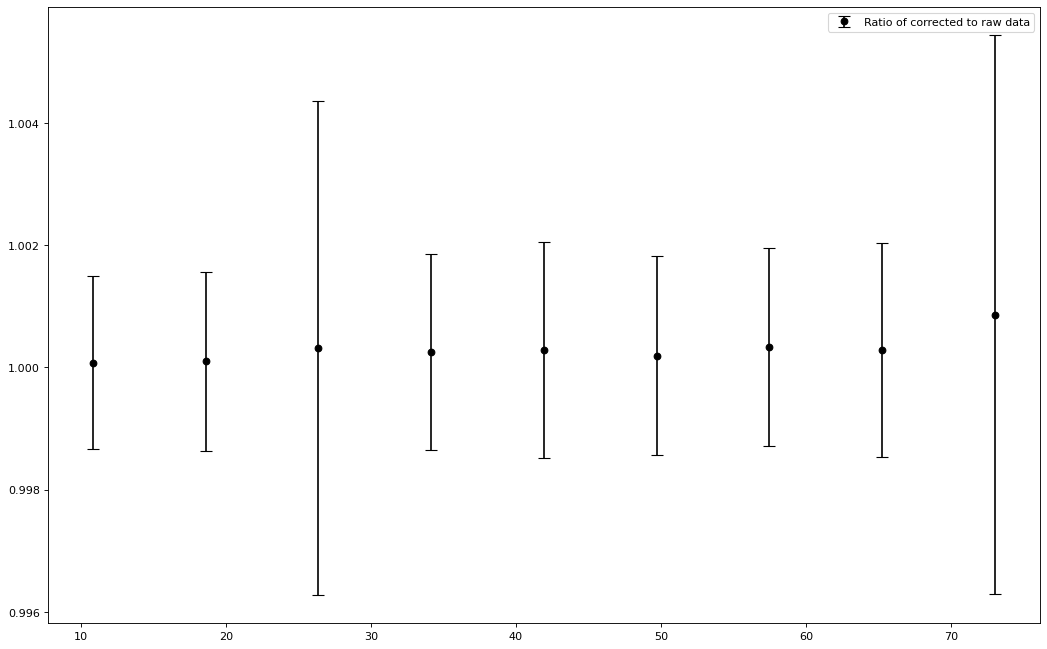

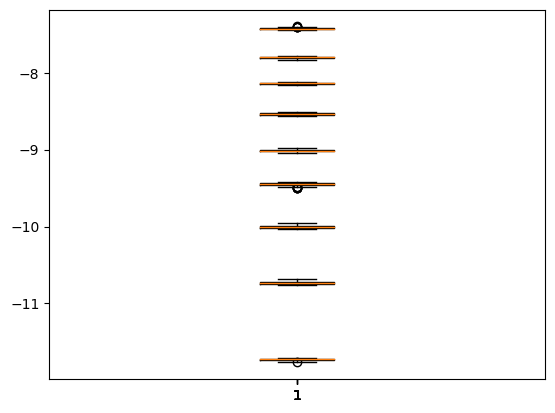

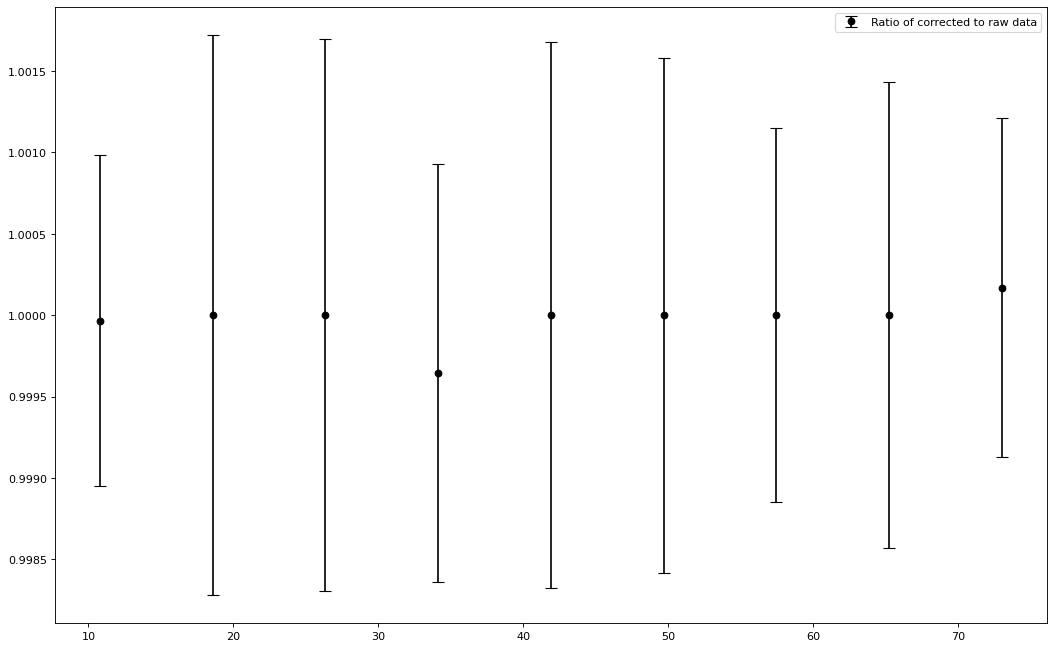

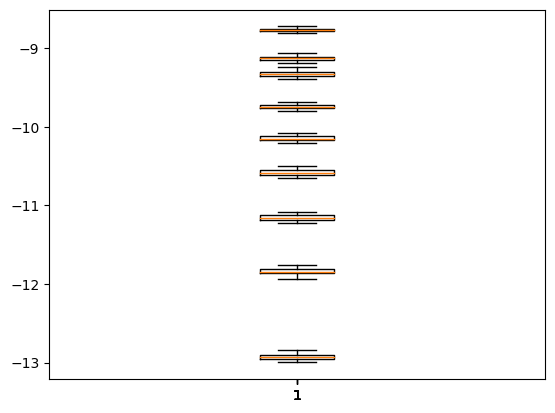

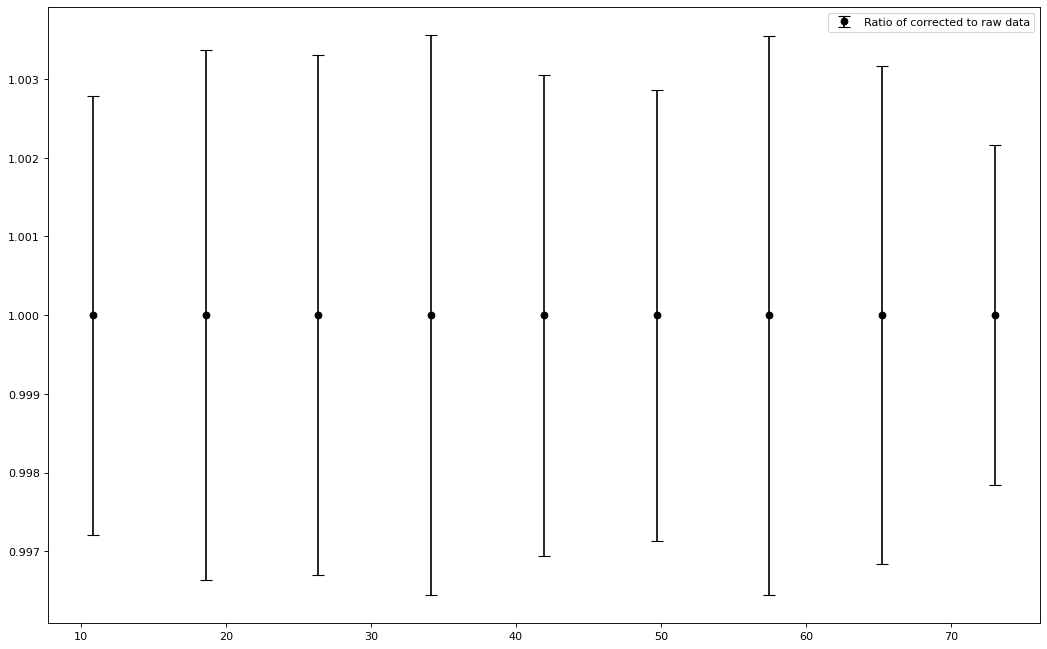

In [4]:
pmt_uncut_no_outliers,det_uncut_no_outliers,pmt_uncut_no_outliers_means, pmt_uncut_no_outliers_std=unpack_and_throw_outliers(uncut,100,pos)
pmt_cut_no_outliers,det_cut_no_outliers,pmt_cut_no_outliers_means, pmt_cut_no_outliers_std=unpack_and_throw_outliers(cut,100,pos)
pmt_ref_no_outliers,det_ref_no_outliers,pmt_ref_no_outliers_means, pmt_ref_no_outliers_std=unpack_and_throw_outliers(ref,100,pos)

In [58]:
#Uncut
det_uncut_no_outliers_means=np.empty(9)
det_uncut_no_outliers_std=np.empty(9)
#Cut
det_cut_no_outliers_means=np.empty(9)
det_cut_no_outliers_std=np.empty(9)
#Refurb
det_ref_no_outliers_means=np.empty(9)
det_ref_no_outliers_std=np.empty(9)

for i in range(9):
    det_uncut_no_outliers_means[i]=np.mean(det_uncut_no_outliers[i])
    det_uncut_no_outliers_std[i]=np.std(det_uncut_no_outliers[i])
    det_cut_no_outliers_means[i]=np.mean(det_cut_no_outliers[i])
    det_cut_no_outliers_std[i]=np.std(det_cut_no_outliers[i])
    det_ref_no_outliers_means[i]=np.mean(det_ref_no_outliers[i])
    det_ref_no_outliers_std[i]=np.std(det_ref_no_outliers[i])
    
# Manually throw out Uncut outlier

print(len(det_uncut_no_outliers_means))
print(len(det_uncut_no_outliers_std))

if len(pmt_uncut_no_outliers_means)!=8:
    pmt_uncut_no_outliers_means.pop(0)
print(len(pmt_uncut_no_outliers_means))
if len(pmt_uncut_no_outliers_std)!=8:
    pmt_uncut_no_outliers_std.pop(0)
print(len(pmt_uncut_no_outliers_std))
if len(det_uncut_no_outliers_means)!=8:
    det_uncut_no_outliers_means=np.delete(det_uncut_no_outliers_means,0)
print(len(det_uncut_no_outliers_means))
if len(det_uncut_no_outliers_std)!=8:
    det_uncut_no_outliers_std=np.delete(det_uncut_no_outliers_std,0)
    print(len(det_uncut_no_outliers_std))
pos2=np.empty(8)
for i in range(1,9):
    pos2[i-1] = pos[i]


9
9
8
8
8
8


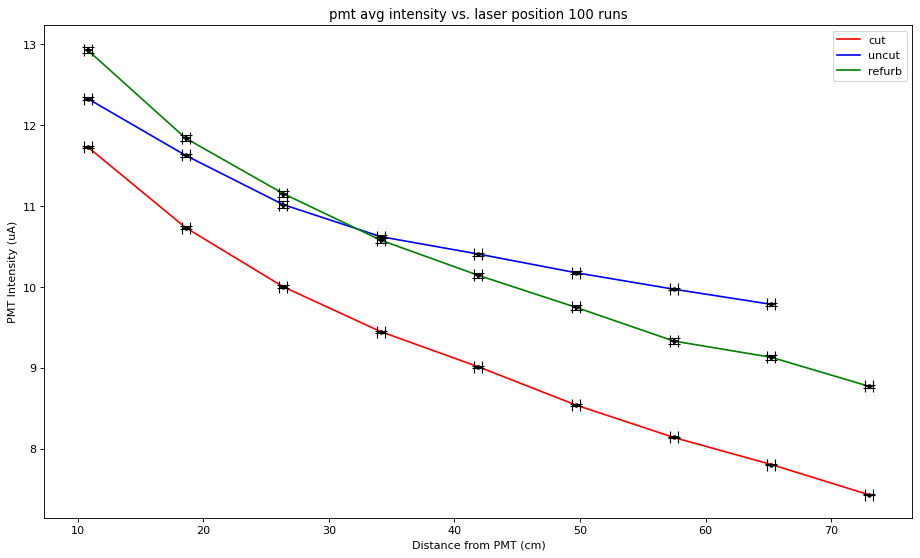

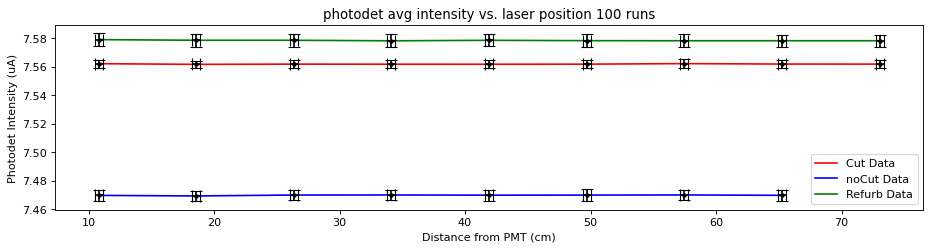

In [6]:
#a_scale_factor=np.mean(refurb_fiber2_sipm_means)/np.mean(fiber2_sipm_means)
fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos2,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_means, xerr=L_err, yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err, yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['cut', 'uncut','refurb'])
plt.show()
fig = plt.figure(figsize=(14, 3), dpi=80)
plt.plot(pos,det_cut_no_outliers_means,color='r')
plt.errorbar(pos,det_cut_no_outliers_means, xerr=L_err,yerr=det_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos2,det_uncut_no_outliers_means,color='b')
plt.errorbar(pos2,det_uncut_no_outliers_means, xerr=L_err,yerr=det_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,det_ref_no_outliers_means,color='g')
plt.errorbar(pos,det_ref_no_outliers_means, xerr=L_err,yerr=det_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.title("photodet avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("Photodet Intensity (uA)")
plt.legend(['Cut Data', 'noCut Data','Refurb Data'])
plt.show()

# fig = plt.figure(figsize=(14, 8), dpi=80)
# plt.plot(pos,np.array(pmt_uncut_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1,color='b')
# plt.errorbar(pos,np.array(pmt_uncut_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1, xerr=L_err, yerr=np.array(pmt_uncut_no_outliers_std)/np.array(pmt_cut_no_outliers_means), fmt=".", color="k",capsize=5)
# plt.title("Ratio of uncut fiber to cut fiber -1")
# plt.xlabel("Distance from PMT (cm)")
# plt.show()

# fig = plt.figure(figsize=(14, 8), dpi=80)
# plt.plot(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1,color='b')
# plt.errorbar(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1, xerr=L_err, yerr=np.array(pmt_ref_no_outliers_std)/np.array(pmt_cut_no_outliers_means), fmt=".", color="k",capsize=5)
# plt.title("Ratio of refurb fiber to cut fiber -1")
# plt.xlabel("Distance from PMT (cm)")
# plt.show()

# fig = plt.figure(figsize=(14, 8), dpi=80)
# plt.plot(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_uncut_no_outliers_means),color='b')
# plt.errorbar(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_uncut_no_outliers_means), xerr=L_err, yerr=np.array(pmt_ref_no_outliers_std)/np.array(pmt_uncut_no_outliers_means), fmt=".", color="k",capsize=5)
# plt.title("Ratio of refurb fiber to uncut fiber")
# plt.xlabel("Distance from PMT (cm)")
# plt.show()


In [60]:
len(pos)

9

In [7]:
# Normalize pmt by det since different levels

pmt_uncut_no_outliers_Nmeans = pmt_uncut_no_outliers_means/det_uncut_no_outliers_means
pmt_cut_no_outliers_Nmeans = pmt_cut_no_outliers_means/det_cut_no_outliers_means
pmt_ref_no_outliers_Nmeans = pmt_ref_no_outliers_means/det_ref_no_outliers_means

pmt_uncut_no_outliers_Nstd = pmt_uncut_no_outliers_std/det_uncut_no_outliers_means
pmt_cut_no_outliers_Nstd = pmt_cut_no_outliers_std/det_cut_no_outliers_means
pmt_ref_no_outliers_Nstd = pmt_ref_no_outliers_std/det_ref_no_outliers_means

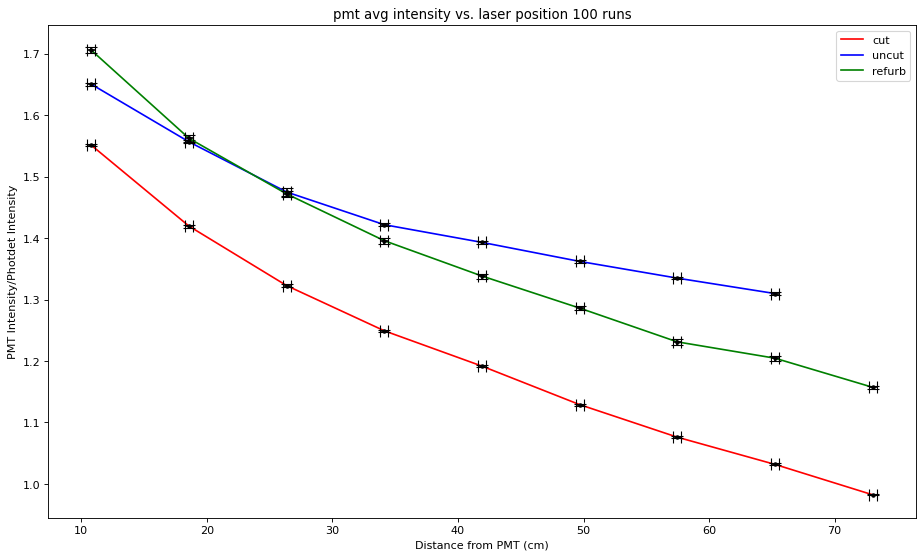

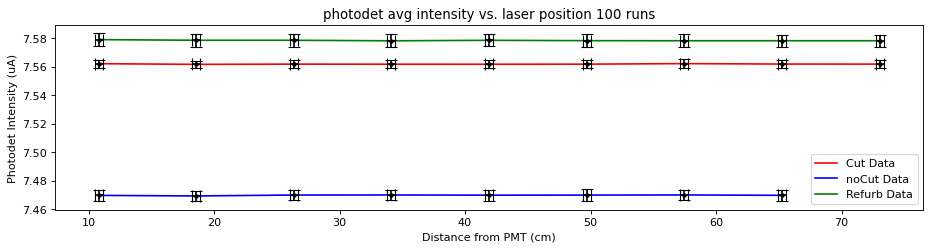

In [100]:
#a_scale_factor=np.mean(refurb_fiber2_sipm_means)/np.mean(fiber2_sipm_means)
fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_cut_no_outliers_Nmeans,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos2,pmt_uncut_no_outliers_Nmeans,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans, xerr=L_err, yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,pmt_ref_no_outliers_Nmeans,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans, xerr=L_err, yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity/Photdet Intensity")
plt.legend(['cut', 'uncut','refurb'])
plt.show()
fig = plt.figure(figsize=(14, 3), dpi=80)
plt.plot(pos,det_cut_no_outliers_means,color='r')
plt.errorbar(pos,det_cut_no_outliers_means, xerr=L_err,yerr=det_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos2,det_uncut_no_outliers_means,color='b')
plt.errorbar(pos2,det_uncut_no_outliers_means, xerr=L_err,yerr=det_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,det_ref_no_outliers_means,color='g')
plt.errorbar(pos,det_ref_no_outliers_means, xerr=L_err,yerr=det_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.title("photodet avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("Photodet Intensity (uA)")
plt.legend(['Cut Data', 'noCut Data','Refurb Data'])
plt.show()

# fig = plt.figure(figsize=(14, 8), dpi=80)
# plt.plot(pos,np.array(pmt_uncut_no_outliers_Nmeans)/np.array(pmt_cut_no_outliers_Nmeans)-1,color='b')
# plt.errorbar(pos,np.array(pmt_uncut_no_outliers_Nmeans)/np.array(pmt_cut_no_outliers_Nmeans)-1, xerr=L_err, yerr=np.array(pmt_uncut_no_outliers_Nstd)/np.array(pmt_cut_no_outliers_Nmeans), fmt=".", color="k",capsize=5)
# plt.title("Ratio of uncut fiber to cut fiber -1")
# plt.xlabel("Distance from PMT (cm)")
# plt.show()

# fig = plt.figure(figsize=(14, 8), dpi=80)
# plt.plot(pos,np.array(pmt_ref_no_outliers_Nmeans)/np.array(pmt_cut_no_outliers_Nmeans)-1,color='b')
# plt.errorbar(pos,np.array(pmt_ref_no_outliers_Nmeans)/np.array(pmt_cut_no_outliers_Nmeans)-1, xerr=L_err, yerr=np.array(pmt_ref_no_outliers_Nstd)/np.array(pmt_cut_no_outliers_means), fmt=".", color="k",capsize=5)
# plt.title("Ratio of refurb fiber to cut fiber -1")
# plt.xlabel("Distance from PMT (cm)")
# plt.show()

# fig = plt.figure(figsize=(14, 8), dpi=80)
# plt.plot(pos,np.array(pmt_ref_no_outliers_Nmeans)/np.array(pmt_uncut_no_outliers_Nmeans),color='b')
# plt.errorbar(pos,np.array(pmt_ref_no_outliers_Nmeans)/np.array(pmt_uncut_no_outliers_Nmeans), xerr=L_err, yerr=np.array(pmt_ref_no_outliers_Nstd)/np.array(pmt_uncut_no_outliers_Nmeans), fmt=".", color="k",capsize=5)
# plt.title("Ratio of refurb fiber to uncut fiber")
# plt.xlabel("Distance from PMT (cm)")
# plt.show()


In [9]:
def Attenuation(x, a, A_L, A_S ):
    return (a*np.exp(-(x)/A_L)+np.abs(1-a)*np.exp(-(x)/A_S))
def Attenuation_w_Reflection(x, a, A_L, A_S, R,L):
    return Attenuation(x,a,A_L,A_S)+R*Attenuation(2*L-x,a,A_L,A_S)

def minimize_without_reflection_cut(Q, a, A_L, A_S):
    res=(pmt_cut_no_outliers_Nmeans-Q*Attenuation(pos,a,A_L,A_S))/pmt_cut_no_outliers_Nstd
    return np.sum(res**2)
def minimize_with_reflection_uncut(Q, a, A_L, A_S,R):
    res=(pmt_uncut_no_outliers_Nmeans-Q*Attenuation_w_Reflection(pos2,a,A_L,A_S,R,UncutL))/pmt_uncut_no_outliers_Nstd
    return np.sum(res**2)
def minimize_with_reflection_ref(Q, a, A_L, A_S,R):
    res=(pmt_ref_no_outliers_Nmeans-Q*Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL))/pmt_ref_no_outliers_Nstd
    return np.sum(res**2)

In [10]:
# Individual Fits

#Uncut
# Create a Minuit object
uncut_Min = Minuit(minimize_with_reflection_uncut, Q=1, a=.73, A_L=450, A_S=20,R=0.5)

# Perform the minimization
result = uncut_Min.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Uncut)")
print(result)
cov_matrix_uncut=uncut_Min.covariance
param_errors=uncut_Min.errors
corr_matrix_uncut = cov_matrix_uncut / np.outer(param_errors, param_errors)
print(corr_matrix_uncut)
print("Optimal parameters:", uncut_Min.values)
print("Parameters Errors:", uncut_Min.errors)


#Cut
# Create a Minuit object
cut_Min = Minuit(minimize_without_reflection_cut, Q=1, a=.73, A_L=322, A_S=10.5)

# Perform the minimization
result = cut_Min.migrad()

# Print the result
print("Minimization result: Fiber without Reflection (Cut)")
print(result)
cov_matrix_cut=cut_Min.covariance
param_errors=cut_Min.errors
corr_matrix_cut = cov_matrix_cut / np.outer(param_errors, param_errors)
print(corr_matrix_cut)
print("Optimal parameters:", cut_Min.values)
print("Parameters Errors:", cut_Min.errors)

#Refurb
# Create a Minuit object
ref_Min = Minuit(minimize_with_reflection_ref, Q=1, a=.73, A_L=450, A_S=10,R=0.5)

# Perform the minimization
result = ref_Min.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Refurb)")
print(result)
cov_matrix_ref=ref_Min.covariance
param_errors=ref_Min.errors
corr_matrix_ref = cov_matrix_ref / np.outer(param_errors, param_errors)
print(corr_matrix_ref)
print("Optimal parameters:", ref_Min.values)
print("Parameters Errors:", ref_Min.errors)

uncut_fit=uncut_Min.values['Q']*Attenuation_w_Reflection(pos2,uncut_Min.values['a'],uncut_Min.values['A_L'],uncut_Min.values['A_S'],uncut_Min.values['R'],UncutL)
cut_fit=cut_Min.values['Q']*Attenuation(pos,cut_Min.values['a'],cut_Min.values['A_L'],cut_Min.values['A_S'])
ref_fit=ref_Min.values['Q']*Attenuation_w_Reflection(pos,ref_Min.values['a'],ref_Min.values['A_L'],ref_Min.values['A_S'],ref_Min.values['R'],RefurbL)

Minimization result: Fiber with Reflection (Uncut)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.89                      │             Nfcn = 1078              │
│ EDM = 0.00221 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─

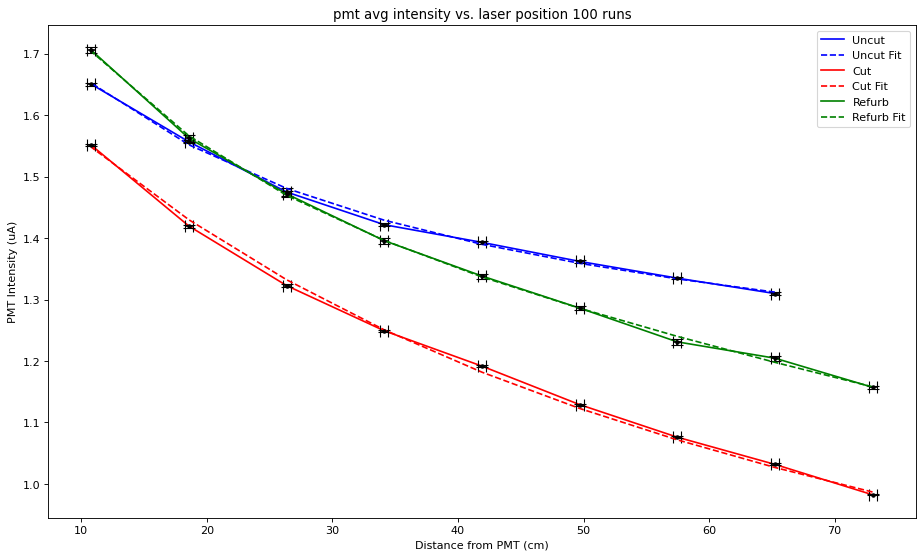

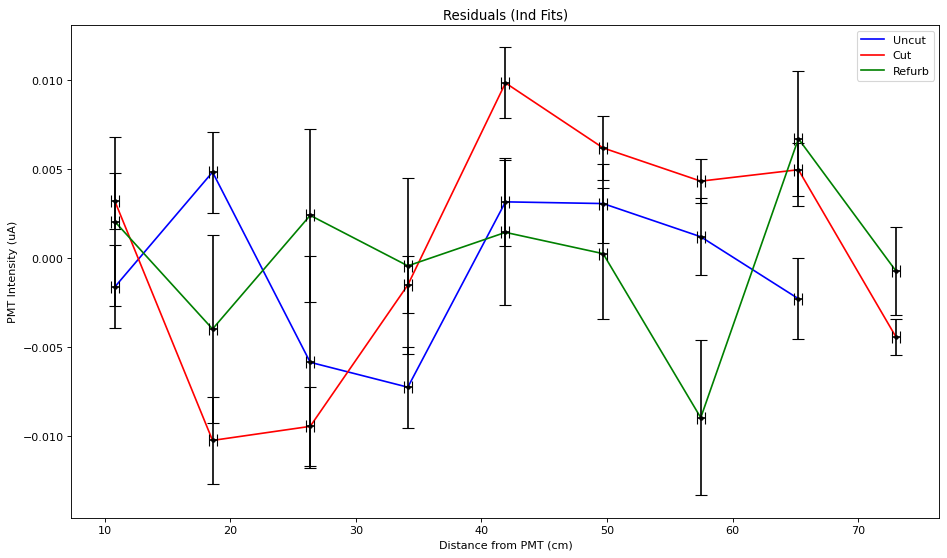

In [11]:
# Individual Fits (One Graph)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos2,pmt_uncut_no_outliers_Nmeans,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_fit,color='b', linestyle='dashed')
# uncut error bars
plt.plot(pos,pmt_cut_no_outliers_Nmeans,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_fit,color='r', linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_Nmeans,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_fit,color='g', linestyle='dashed')
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals
fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos2,pmt_uncut_no_outliers_Nmeans-uncut_fit,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans-uncut_fit, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_Nmeans-cut_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans-cut_fit, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_Nmeans-ref_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans-ref_fit, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Residuals (Ind Fits)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Cut','Refurb'])
plt.show()

In [12]:
#Joint (all three) Min

def joint_minimization_all(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_cut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection(pos2,a,A_L,A_S,R,UncutL),Attenuation(pos,a,A_L,A_S),Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_cut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_uncut_cut(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_cut_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection(pos2,a,A_L,A_S,R,UncutL),Attenuation(pos,a,A_L,A_S)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_cut_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_ref_cut(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_cut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation(pos,a,A_L,A_S),Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL)])
    err=np.concatenate([pmt_cut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_uncut_ref(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection(pos2,a,A_L,A_S,R,UncutL),Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)

# Create a Minuit object
Joint_Min = Minuit(joint_minimization_all, Q=1, a=.73, A_L=450, A_S=20, R=0.5)
UncutJoint_Min = Minuit(joint_minimization_uncut_cut, Q=1, a=.73, A_L=450, A_S=20, R=0.5)
RefJoint_Min = Minuit(joint_minimization_ref_cut, Q=1, a=.73, A_L=450, A_S=20, R=0.5)
URJoint_Min = Minuit(joint_minimization_uncut_ref, Q=1, a=.73, A_L=450, A_S=20, R=0.5)

# Perform the minimization
result1 = Joint_Min.migrad()
result2 = UncutJoint_Min.migrad()
result3 = RefJoint_Min.migrad()
result4 = URJoint_Min.migrad()

# Print the result
print("Minimization result: Joint Fit (all three)")
print(result1)
cov_matrix_Joint=Joint_Min.covariance
param_errors1=Joint_Min.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors1, param_errors1)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Min.values)
print("Parameters Errors:", Joint_Min.errors)

print("Minimization result: Joint Fit (Uncut/Cut)")
print(result2)
cov_matrix_UncutJoint=UncutJoint_Min.covariance
param_errors2=UncutJoint_Min.errors
corr_matrix_UncutJoint = cov_matrix_UncutJoint / np.outer(param_errors2, param_errors2)
print(corr_matrix_UncutJoint)
print("Optimal parameters:", UncutJoint_Min.values)
print("Parameters Errors:", UncutJoint_Min.errors)

print("Minimization result: Joint Fit (Refurb/Cut)")
print(result3)
cov_matrix_RefJoint=RefJoint_Min.covariance
param_errors3=RefJoint_Min.errors
corr_matrix_RefJoint = cov_matrix_RefJoint / np.outer(param_errors3, param_errors3)
print(corr_matrix_RefJoint)
print("Optimal parameters:", RefJoint_Min.values)
print("Parameters Errors:", RefJoint_Min.errors)

print("Minimization result: Joint Fit (Uncut/Refurb)")
print(result4)
cov_matrix_URJoint=URJoint_Min.covariance
param_errors4=URJoint_Min.errors
corr_matrix_URJoint = cov_matrix_URJoint / np.outer(param_errors4, param_errors4)
print(corr_matrix_URJoint)
print("Optimal parameters:", URJoint_Min.values)
print("Parameters Errors:", URJoint_Min.errors)

uncut_Joint_all_fit=Joint_Min.values['Q']*Attenuation_w_Reflection(pos2,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'],Joint_Min.values['R'],UncutL)
cut_Joint_all_fit=Joint_Min.values['Q']*Attenuation(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'])
ref_Joint_all_fit=Joint_Min.values['Q']*Attenuation_w_Reflection(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'],Joint_Min.values['R'],RefurbL)

uncut_UncutJoint_fit=UncutJoint_Min.values['Q']*Attenuation_w_Reflection(pos2,UncutJoint_Min.values['a'],UncutJoint_Min.values['A_L'],UncutJoint_Min.values['A_S'],UncutJoint_Min.values['R'],UncutL)
cut_UncutJoint_fit=UncutJoint_Min.values['Q']*Attenuation(pos,UncutJoint_Min.values['a'],UncutJoint_Min.values['A_L'],UncutJoint_Min.values['A_S'])

ref_RefJoint_fit=RefJoint_Min.values['Q']*Attenuation_w_Reflection(pos,RefJoint_Min.values['a'],RefJoint_Min.values['A_L'],RefJoint_Min.values['A_S'],RefJoint_Min.values['R'],RefurbL)
cut_RefJoint_fit=RefJoint_Min.values['Q']*Attenuation(pos,RefJoint_Min.values['a'],RefJoint_Min.values['A_L'],RefJoint_Min.values['A_S'])

uncut_URJoint_fit=URJoint_Min.values['Q']*Attenuation_w_Reflection(pos2,URJoint_Min.values['a'],URJoint_Min.values['A_L'],URJoint_Min.values['A_S'],URJoint_Min.values['R'],UncutL)
ref_URJoint_fit=URJoint_Min.values['Q']*Attenuation_w_Reflection(pos,URJoint_Min.values['a'],URJoint_Min.values['A_L'],URJoint_Min.values['A_S'],URJoint_Min.values['R'],RefurbL)


Minimization result: Joint Fit (all three)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3003                       │              Nfcn = 732              │
│ EDM = 6.58e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─────────

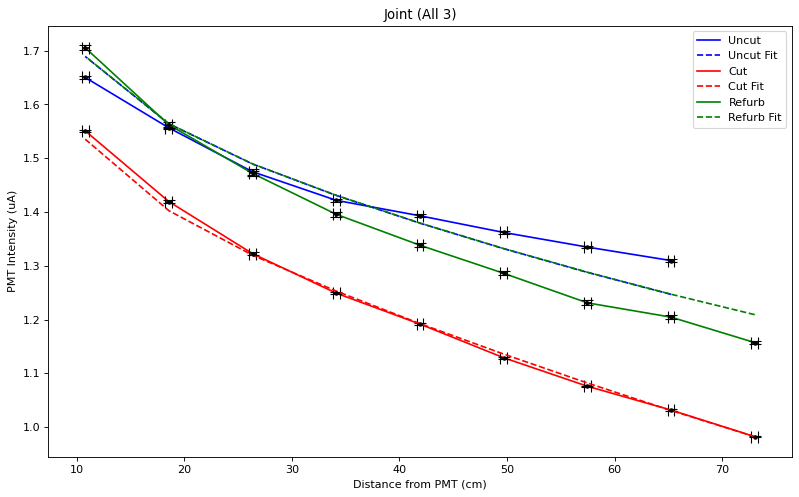

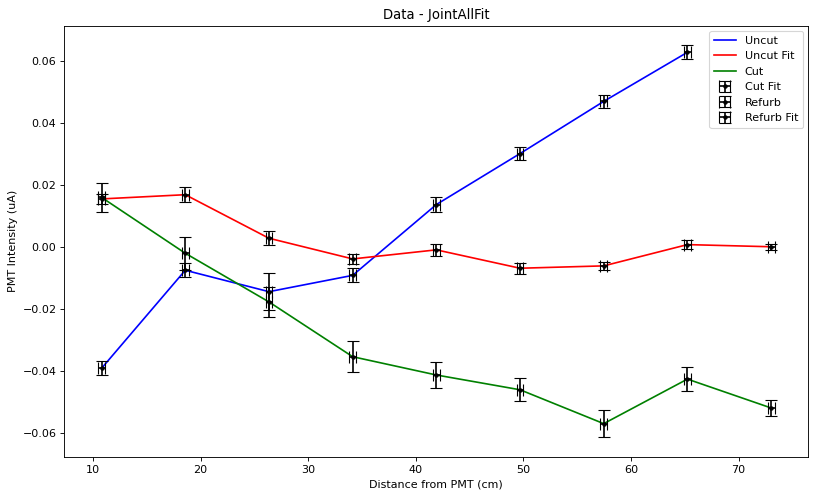

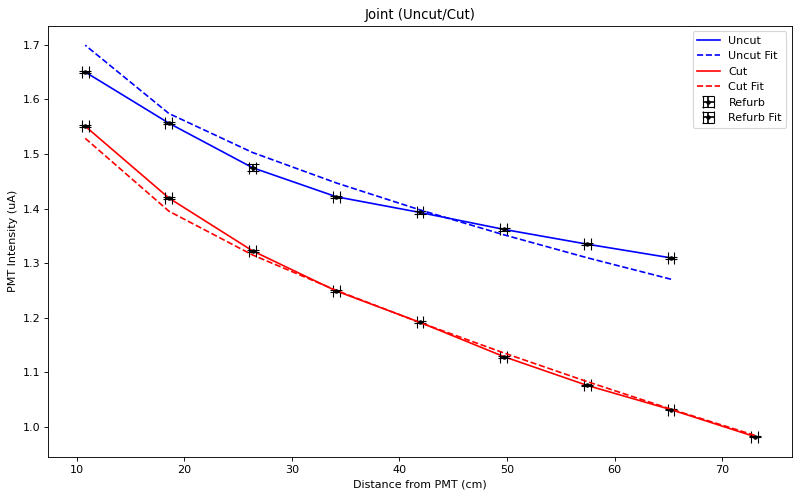

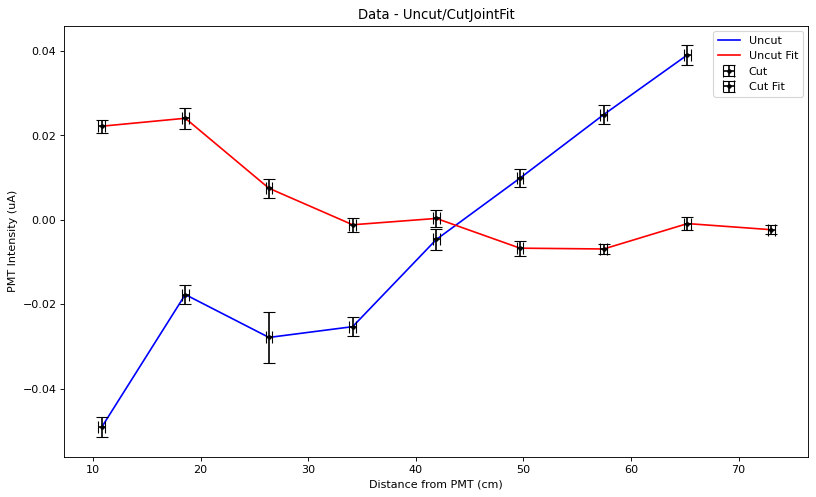

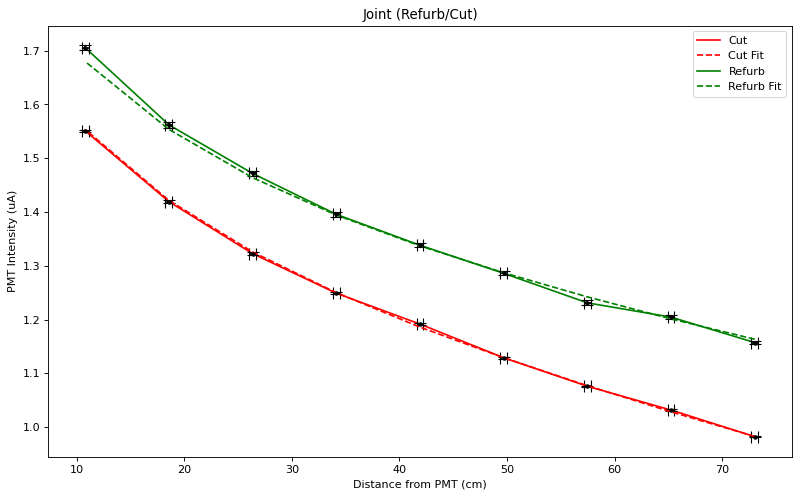

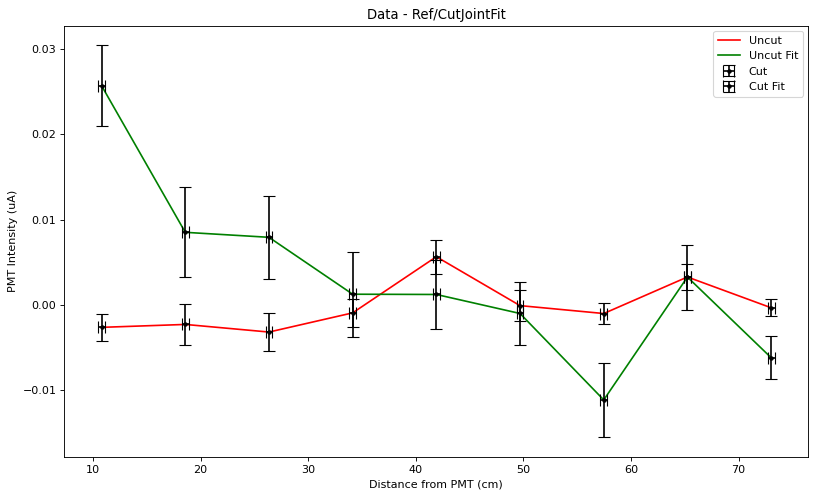

ValueError: 'yerr' (shape: (9,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (8,))

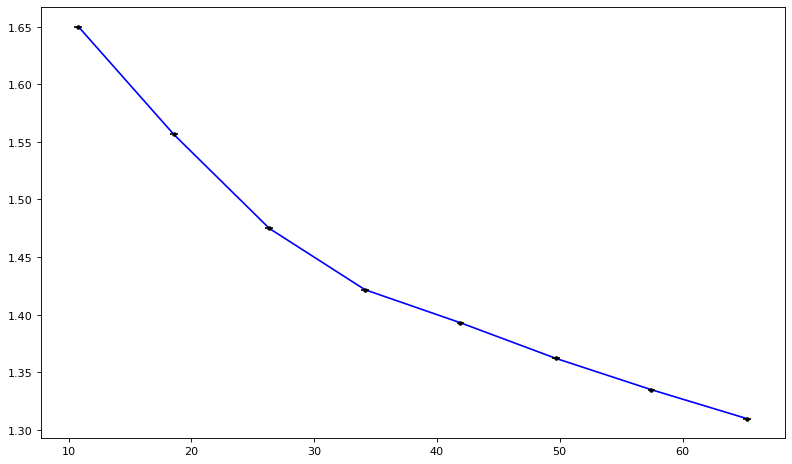

In [13]:
# Joint all 3 Fits (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_Nmeans,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_Joint_all_fit,color='b',linestyle='dashed')
plt.plot(pos,pmt_cut_no_outliers_Nmeans,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_Joint_all_fit,color='r',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_Nmeans,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_Joint_all_fit,color='g',linestyle='dashed')
plt.title("Joint (All 3)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)
plt.plot(pos2,pmt_uncut_no_outliers_Nmeans-uncut_Joint_all_fit,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans-uncut_Joint_all_fit, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_Nmeans-cut_Joint_all_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans-cut_Joint_all_fit, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_Nmeans-ref_Joint_all_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans-ref_Joint_all_fit, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Data - JointAllFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Uncut/Cut (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_Nmeans,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_UncutJoint_fit,color='b',linestyle='dashed')
plt.plot(pos,pmt_cut_no_outliers_Nmeans,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_UncutJoint_fit,color='r',linestyle='dashed')

plt.title("Joint (Uncut/Cut)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)
plt.plot(pos2,pmt_uncut_no_outliers_Nmeans-uncut_UncutJoint_fit,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans-uncut_UncutJoint_fit, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_Nmeans-cut_UncutJoint_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans-cut_UncutJoint_fit, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Data - Uncut/CutJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Ref/Cut (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_cut_no_outliers_Nmeans,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_RefJoint_fit,color='r',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_Nmeans,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_RefJoint_fit,color='g',linestyle='dashed')
plt.title("Joint (Refurb/Cut)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_cut_no_outliers_Nmeans-cut_RefJoint_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans-cut_RefJoint_fit, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_Nmeans-ref_RefJoint_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans-ref_RefJoint_fit, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Data - Ref/CutJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Uncut/Ref (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_Nmeans,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_URJoint_fit,color='b',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_Nmeans,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_URJoint_fit,color='g',linestyle='dashed')
plt.title("Joint (Uncut/Ref)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_Nmeans-uncut_URJoint_fit,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans-uncut_URJoint_fit, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_Nmeans-ref_URJoint_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans-ref_URJoint_fit, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Data - Uncut/RefJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

In [14]:
# Try with const in model

def Attenuation_w_const(x, a, b, A_L, A_S, A_x ):
    return (a*np.exp(-(x)/A_L)+np.abs(1-a-b)*np.exp(-(x)/A_S)) + b*A_x
def Attenuation_w_Reflection_w_const(x, a,b, A_L, A_S, A_x, R,L):
    return Attenuation_w_const(x,a,b,A_L,A_S,A_x)+R*Attenuation_w_const(2*L-x,a,b,A_L,A_S,A_x)

In [15]:
#Joint (all three) Min

def joint_minimization_all_c(Q,a,b,A_L,A_S,A_x,R):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_cut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection_w_const(pos2,a,b,A_L,A_S,A_x,R,UncutL),Attenuation_w_const(pos,a,b,A_L,A_S,A_x),Attenuation_w_Reflection_w_const(pos,a,b,A_L,A_S,A_x,R,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_cut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_uncut_cut_c(Q,a,b,A_L,A_S,A_x,R):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_cut_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection_w_const(pos2,a,b,A_L,A_S,A_x,R,UncutL),Attenuation_w_const(pos,a,b,A_L,A_S,A_x)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_cut_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_ref_cut_c(Q,a,b,A_L,A_S,A_x,R):
    data=np.concatenate([pmt_cut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_const(pos,a,b,A_L,A_S,A_x),Attenuation_w_Reflection_w_const(pos,a,b,A_L,A_S,A_x,R,RefurbL)])
    err=np.concatenate([pmt_cut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_uncut_ref_c(Q,a,b,A_L,A_S,A_x,R):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection_w_const(pos2,a,b,A_L,A_S,A_x,R,UncutL),Attenuation_w_Reflection_w_const(pos,a,b,A_L,A_S,A_x,R,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)

# Create a Minuit object
Joint_Min_c = Minuit(joint_minimization_all_c, Q=1, a=.73,b=0.2, A_L=450, A_S=20,A_x=0, R=0.5)
UncutJoint_Min_c = Minuit(joint_minimization_uncut_cut_c, Q=1, a=.73,b=0.2, A_L=450, A_S=20,A_x=0, R=0.5)
RefJoint_Min_c = Minuit(joint_minimization_ref_cut_c, Q=1, a=.73,b=0.2, A_L=450, A_S=20,A_x=0, R=0.5)
URJoint_Min_c = Minuit(joint_minimization_uncut_ref_c, Q=1, a=.73,b=0.2, A_L=450, A_S=20,A_x=0, R=0.5)

# Perform the minimization
result1 = Joint_Min_c.migrad()
result2 = UncutJoint_Min_c.migrad()
result3 = RefJoint_Min_c.migrad()
result4 = URJoint_Min_c.migrad()

# Print the result
print("Minimization result: Joint Fit (all three)")
print(result1)
cov_matrix_Joint=Joint_Min_c.covariance
param_errors1=Joint_Min_c.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors1, param_errors1)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Min_c.values)
print("Parameters Errors:", Joint_Min_c.errors)

print("Minimization result: Joint Fit (Uncut/Cut)")
print(result2)
cov_matrix_UncutJoint=UncutJoint_Min_c.covariance
param_errors2=UncutJoint_Min_c.errors
corr_matrix_UncutJoint = cov_matrix_UncutJoint / np.outer(param_errors2, param_errors2)
print(corr_matrix_UncutJoint)
print("Optimal parameters:", UncutJoint_Min_c.values)
print("Parameters Errors:", UncutJoint_Min_c.errors)

print("Minimization result: Joint Fit (Refurb/Cut)")
print(result3)
cov_matrix_RefJoint=RefJoint_Min_c.covariance
param_errors3=RefJoint_Min_c.errors
corr_matrix_RefJoint = cov_matrix_RefJoint / np.outer(param_errors3, param_errors3)
print(corr_matrix_RefJoint)
print("Optimal parameters:", RefJoint_Min_c.values)
print("Parameters Errors:", RefJoint_Min_c.errors)

print("Minimization result: Joint Fit (Uncut/Refurb)")
print(result4)
cov_matrix_URJoint=URJoint_Min_c.covariance
param_errors4=URJoint_Min_c.errors
corr_matrix_URJoint = cov_matrix_URJoint / np.outer(param_errors4, param_errors4)
print(corr_matrix_URJoint)
print("Optimal parameters:", URJoint_Min_c.values)
print("Parameters Errors:", URJoint_Min_c.errors)

# uncut_Joint_all_fit=Joint_Min_c.values['Q']*Attenuation_w_Reflection(pos2,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'],Joint_Min.values['R'],UncutL)
# cut_Joint_all_fit=Joint_Min_c.values['Q']*Attenuation(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'])
# ref_Joint_all_fit=Joint_Min_c.values['Q']*Attenuation_w_Reflection(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'],Joint_Min.values['R'],RefurbL)

# uncut_UncutJoint_fit=UncutJoint_Min.values['Q']*Attenuation_w_Reflection(pos2,UncutJoint_Min.values['a'],UncutJoint_Min.values['A_L'],UncutJoint_Min.values['A_S'],UncutJoint_Min.values['R'],UncutL)
# cut_UncutJoint_fit=UncutJoint_Min.values['Q']*Attenuation(pos,UncutJoint_Min.values['a'],UncutJoint_Min.values['A_L'],UncutJoint_Min.values['A_S'])

# ref_RefJoint_fit=RefJoint_Min.values['Q']*Attenuation_w_Reflection(pos,RefJoint_Min.values['a'],RefJoint_Min.values['A_L'],RefJoint_Min.values['A_S'],RefJoint_Min.values['R'],RefurbL)
# cut_RefJoint_fit=RefJoint_Min.values['Q']*Attenuation(pos,RefJoint_Min.values['a'],RefJoint_Min.values['A_L'],RefJoint_Min.values['A_S'])

# uncut_URJoint_fit=URJoint_Min.values['Q']*Attenuation_w_Reflection(pos2,URJoint_Min.values['a'],URJoint_Min.values['A_L'],URJoint_Min.values['A_S'],URJoint_Min.values['R'],UncutL)
# ref_URJoint_fit=URJoint_Min.values['Q']*Attenuation_w_Reflection(pos,URJoint_Min.values['a'],URJoint_Min.values['A_L'],URJoint_Min.values['A_S'],URJoint_Min.values['R'],RefurbL)


Minimization result: Joint Fit (all three)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3059                       │             Nfcn = 1150              │
│ EDM = 12.1 (Goal: 0.0002)        │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─────────

In [16]:
# Try with diff long/short atten reflection coefficients

def Attenuation_w_Reflection2(x, a, A_L, A_S, S, T, L):
    return Attenuation(x,a,A_L,A_S)+S*a*np.exp(-(x)/A_L)+T*np.abs(1-a)*np.exp(-(x)/A_S)

def minimize_with_reflection_uncut2(Q, a, A_L, A_S,S,T):
    res=(pmt_uncut_no_outliers_Nmeans-Q*Attenuation_w_Reflection2(pos2,a,A_L,A_S,S,T,UncutL))/pmt_uncut_no_outliers_Nstd
    return np.sum(res**2)
def minimize_with_reflection_cut2(Q, a, A_L, A_S,S,T):
    AveL=(UncutL+RefurbL)/2
    res=(pmt_cut_no_outliers_Nmeans-Q*Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,AveL))/pmt_cut_no_outliers_Nstd
    return np.sum(res**2)
def minimize_with_reflection_ref2(Q, a, A_L, A_S,S,T):
    res=(pmt_ref_no_outliers_Nmeans-Q*Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,RefurbL))/pmt_ref_no_outliers_Nstd
    return np.sum(res**2)

#Uncut
# Create a Minuit object
uncut_Min2 = Minuit(minimize_with_reflection_uncut2, Q=1, a=.73, A_L=450, A_S=20,S=0.5,T=0.5)

# Perform the minimization
result = uncut_Min2.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Uncut)")
print(result)
cov_matrix_uncut=uncut_Min2.covariance
param_errors=uncut_Min2.errors
corr_matrix_uncut = cov_matrix_uncut / np.outer(param_errors, param_errors)
print(corr_matrix_uncut)
print("Optimal parameters:", uncut_Min2.values)
print("Parameters Errors:", uncut_Min2.errors)

#Refurb
# Create a Minuit object
ref_Min2 = Minuit(minimize_with_reflection_ref2, Q=1, a=.73, A_L=450, A_S=10,S=0.5,T=0.5)

# Perform the minimization
result = ref_Min2.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Refurb)")
print(result)
cov_matrix_ref=ref_Min2.covariance
param_errors=ref_Min2.errors
corr_matrix_ref = cov_matrix_ref / np.outer(param_errors, param_errors)
print(corr_matrix_ref)
print("Optimal parameters:", ref_Min2.values)
print("Parameters Errors:", ref_Min2.errors)

uncut_fit=uncut_Min.values['Q']*Attenuation_w_Reflection(pos2,uncut_Min.values['a'],uncut_Min.values['A_L'],uncut_Min.values['A_S'],uncut_Min.values['R'],UncutL)
cut_fit=cut_Min.values['Q']*Attenuation(pos,cut_Min.values['a'],cut_Min.values['A_L'],cut_Min.values['A_S'])
ref_fit=ref_Min.values['Q']*Attenuation_w_Reflection(pos,ref_Min.values['a'],ref_Min.values['A_L'],ref_Min.values['A_S'],ref_Min.values['R'],RefurbL)

Minimization result: Fiber with Reflection (Uncut)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.74                      │              Nfcn = 374              │
│ EDM = 5.6e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─

In [21]:
#Joint2 (all three) Min

def joint_minimization_all2(Q,a,A_L,A_S,S,T):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_cut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection2(pos2,a,A_L,A_S,S,T,UncutL),Attenuation(pos,a,A_L,A_S),Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_cut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_uncut_cut2(Q,a,A_L,A_S,S,T):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_cut_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection2(pos2,a,A_L,A_S,S,T,UncutL),Attenuation(pos,a,A_L,A_S)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_cut_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_ref_cut2(Q,a,A_L,A_S,S,T):
    data=np.concatenate([pmt_cut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation(pos,a,A_L,A_S),Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,RefurbL)])
    err=np.concatenate([pmt_cut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_uncut_ref2(Q,a,A_L,A_S,S,T):
    data=np.concatenate([pmt_uncut_no_outliers_Nmeans,pmt_ref_no_outliers_Nmeans])
    model=Q*np.concatenate([Attenuation_w_Reflection2(pos2,a,A_L,A_S,S,T,UncutL),Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_Nstd,pmt_ref_no_outliers_Nstd])
    cost=(data-model)/err
    return np.sum(cost**2)

# Create a Minuit object
Joint_Min2 = Minuit(joint_minimization_all2, Q=1, a=.73, A_L=450, A_S=20, S=0.5, T=0.5)
UncutJoint_Min2 = Minuit(joint_minimization_uncut_cut2, Q=1, a=.73, A_L=450, A_S=20, S=0.5, T=0.5)
RefJoint_Min2 = Minuit(joint_minimization_ref_cut2, Q=1, a=.73, A_L=450, A_S=20, S=0.5, T=0.5)
URJoint_Min2 = Minuit(joint_minimization_uncut_ref2, Q=1, a=.73, A_L=450, A_S=20, S=0.5, T=0.5)

# Perform the minimization
result1 = Joint_Min2.migrad()
result2 = UncutJoint_Min2.migrad()
result3 = RefJoint_Min2.migrad()
result4 = URJoint_Min2.migrad()

# Print the result
print("Minimization result: Joint Fit (all three)")
print(result1)
cov_matrix_Joint=Joint_Min2.covariance
param_errors1=Joint_Min2.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors1, param_errors1)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Min2.values)
print("Parameters Errors:", Joint_Min2.errors)

print("Minimization result: Joint Fit (Uncut/Cut)")
print(result2)
cov_matrix_UncutJoint=UncutJoint_Min2.covariance
param_errors2=UncutJoint_Min2.errors
corr_matrix_UncutJoint = cov_matrix_UncutJoint / np.outer(param_errors2, param_errors2)
print(corr_matrix_UncutJoint)
print("Optimal parameters:", UncutJoint_Min2.values)
print("Parameters Errors:", UncutJoint_Min2.errors)

print("Minimization result: Joint Fit (Refurb/Cut)")
print(result3)
cov_matrix_RefJoint=RefJoint_Min2.covariance
param_errors3=RefJoint_Min2.errors
corr_matrix_RefJoint = cov_matrix_RefJoint / np.outer(param_errors3, param_errors3)
print(corr_matrix_RefJoint)
print("Optimal parameters:", RefJoint_Min2.values)
print("Parameters Errors:", RefJoint_Min2.errors)

print("Minimization result: Joint Fit (Uncut/Refurb)")
print(result4)
cov_matrix_URJoint=URJoint_Min2.covariance
param_errors4=URJoint_Min2.errors
corr_matrix_URJoint = cov_matrix_URJoint / np.outer(param_errors4, param_errors4)
print(corr_matrix_URJoint)
print("Optimal parameters:", URJoint_Min2.values)
print("Parameters Errors:", URJoint_Min2.errors)

uncut_Joint_all_fit2=Joint_Min2.values['Q']*Attenuation_w_Reflection2(pos2,Joint_Min2.values['a'],Joint_Min2.values['A_L'],Joint_Min2.values['A_S'],Joint_Min2.values['S'],Joint_Min2.values['T'],UncutL)
cut_Joint_all_fit2=Joint_Min2.values['Q']*Attenuation(pos,Joint_Min2.values['a'],Joint_Min2.values['A_L'],Joint_Min2.values['A_S'])
ref_Joint_all_fit2=Joint_Min2.values['Q']*Attenuation_w_Reflection2(pos,Joint_Min2.values['a'],Joint_Min2.values['A_L'],Joint_Min2.values['A_S'],Joint_Min2.values['S'],Joint_Min2.values['T'],RefurbL)

uncut_UncutJoint_fit2=UncutJoint_Min2.values['Q']*Attenuation_w_Reflection2(pos2,UncutJoint_Min2.values['a'],UncutJoint_Min2.values['A_L'],UncutJoint_Min2.values['A_S'],UncutJoint_Min2.values['S'],UncutJoint_Min2.values['T'],UncutL)
cut_UncutJoint_fit2=UncutJoint_Min2.values['Q']*Attenuation(pos,UncutJoint_Min2.values['a'],UncutJoint_Min2.values['A_L'],UncutJoint_Min2.values['A_S'])

ref_RefJoint_fit2=RefJoint_Min2.values['Q']*Attenuation_w_Reflection2(pos,RefJoint_Min2.values['a'],RefJoint_Min2.values['A_L'],RefJoint_Min2.values['A_S'],RefJoint_Min2.values['S'],RefJoint_Min2.values['T'],RefurbL)
cut_RefJoint_fit2=RefJoint_Min2.values['Q']*Attenuation(pos,RefJoint_Min2.values['a'],RefJoint_Min2.values['A_L'],RefJoint_Min2.values['A_S'])

uncut_URJoint_fit2=URJoint_Min2.values['Q']*Attenuation_w_Reflection2(pos2,URJoint_Min2.values['a'],URJoint_Min2.values['A_L'],URJoint_Min2.values['A_S'],URJoint_Min2.values['S'],URJoint_Min2.values['T'],UncutL)
ref_URJoint_fit2=URJoint_Min2.values['Q']*Attenuation_w_Reflection2(pos,URJoint_Min2.values['a'],URJoint_Min2.values['A_L'],URJoint_Min2.values['A_S'],URJoint_Min2.values['S'],URJoint_Min2.values['T'],RefurbL)

Minimization result: Joint Fit (all three)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2830                       │              Nfcn = 586              │
│ EDM = 3.66e-06 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─────────

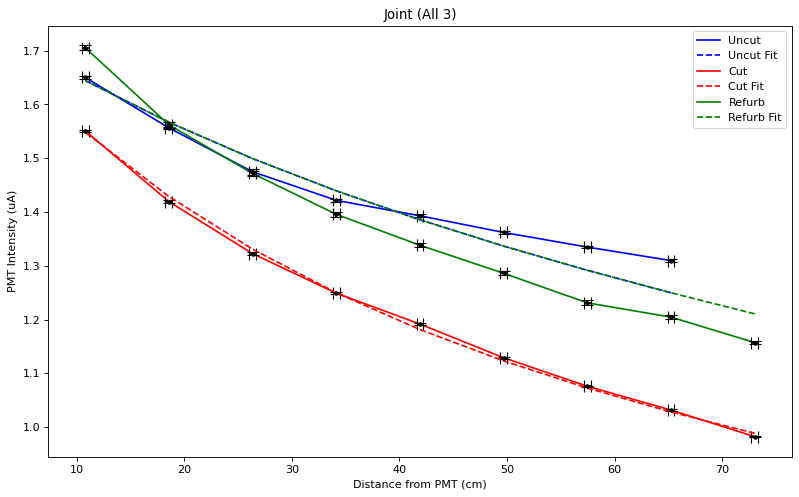

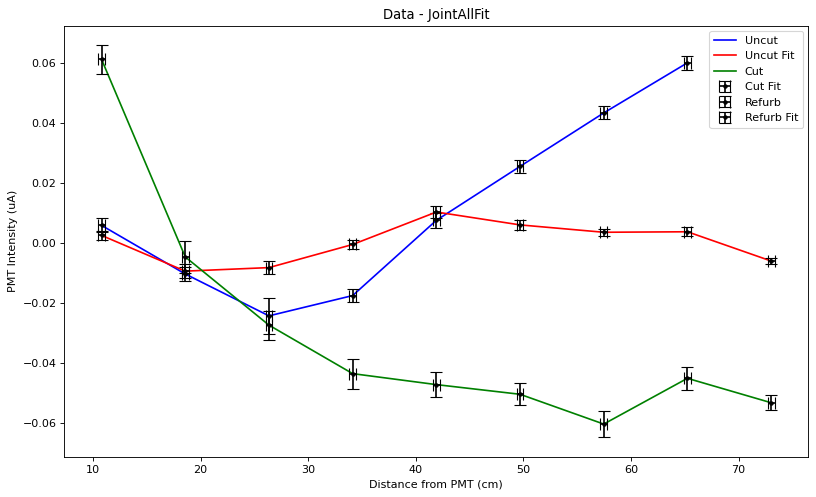

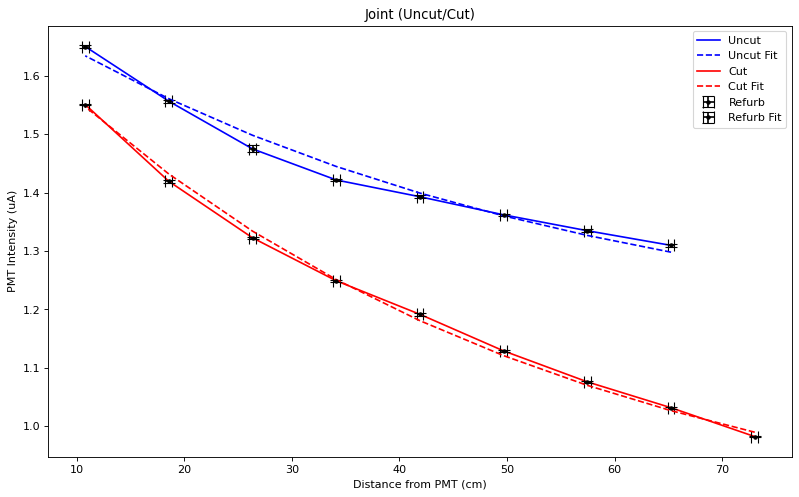

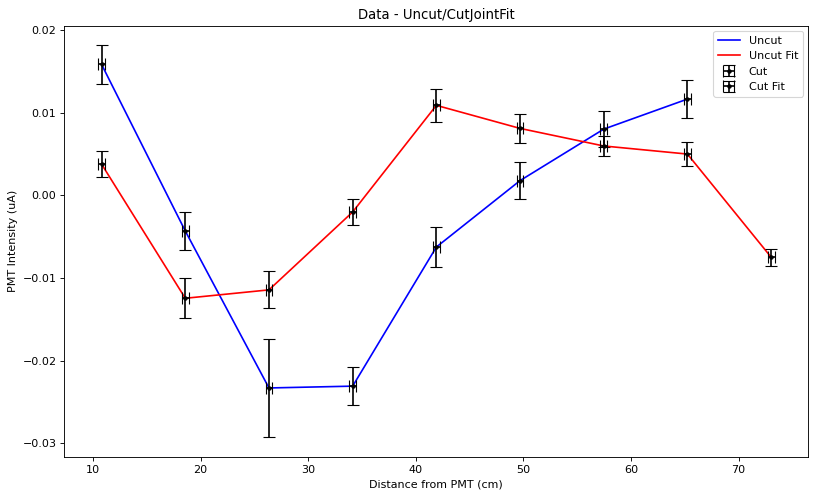

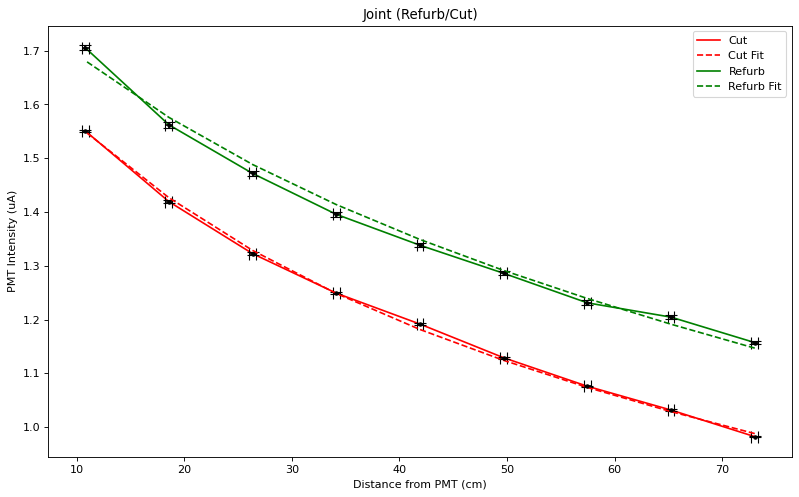

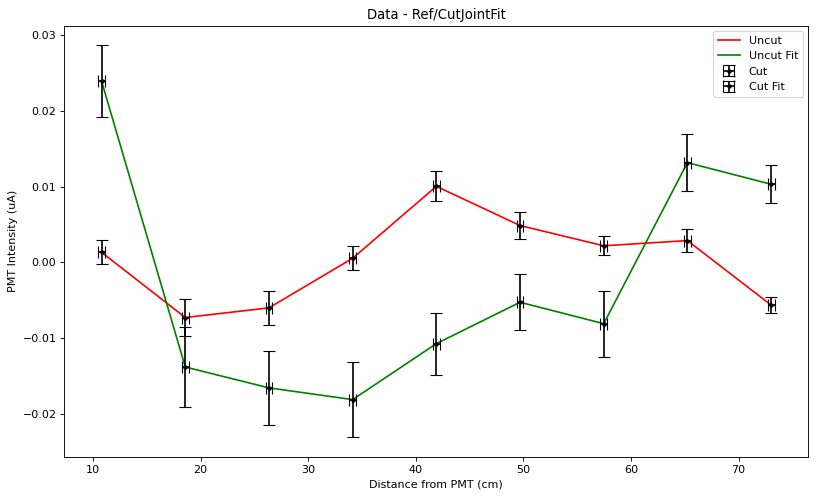

ValueError: 'yerr' (shape: (9,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (8,))

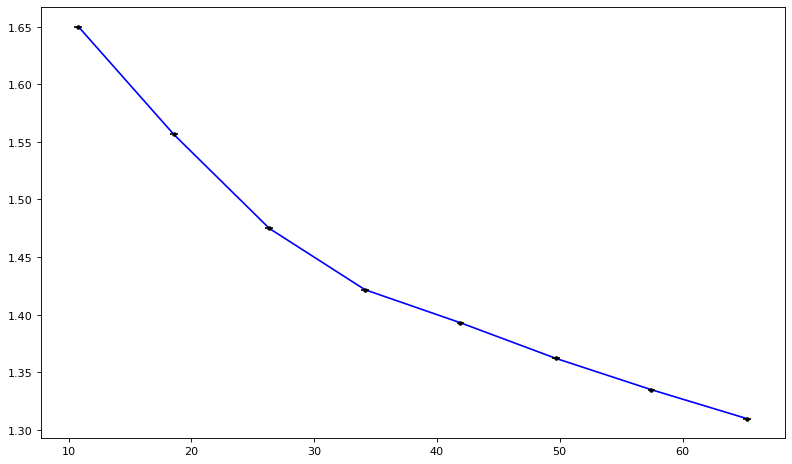

In [22]:
# Joint2 all 3 Fits (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_Nmeans,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_Joint_all_fit2,color='b',linestyle='dashed')
plt.plot(pos,pmt_cut_no_outliers_Nmeans,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_Joint_all_fit2,color='r',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_Nmeans,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_Joint_all_fit2,color='g',linestyle='dashed')
plt.title("Joint (All 3)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)
plt.plot(pos2,pmt_uncut_no_outliers_Nmeans-uncut_Joint_all_fit2,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans-uncut_Joint_all_fit2, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_Nmeans-cut_Joint_all_fit2,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans-cut_Joint_all_fit2, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_Nmeans-ref_Joint_all_fit2,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans-ref_Joint_all_fit2, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Data - JointAllFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Uncut/Cut (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_Nmeans,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_UncutJoint_fit2,color='b',linestyle='dashed')
plt.plot(pos,pmt_cut_no_outliers_Nmeans,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_UncutJoint_fit2,color='r',linestyle='dashed')

plt.title("Joint (Uncut/Cut)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)
plt.plot(pos2,pmt_uncut_no_outliers_Nmeans-uncut_UncutJoint_fit2,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans-uncut_UncutJoint_fit2, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_Nmeans-cut_UncutJoint_fit2,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans-cut_UncutJoint_fit2, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Data - Uncut/CutJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Ref/Cut (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_cut_no_outliers_Nmeans,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_RefJoint_fit2,color='r',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_Nmeans,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_RefJoint_fit2,color='g',linestyle='dashed')
plt.title("Joint (Refurb/Cut)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_cut_no_outliers_Nmeans-cut_RefJoint_fit2,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_Nmeans-cut_RefJoint_fit2, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_Nmeans-ref_RefJoint_fit2,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans-ref_RefJoint_fit2, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Data - Ref/CutJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Uncut/Ref (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_Nmeans,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans, xerr=L_err,yerr=pmt_cut_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_URJoint_fit2,color='b',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_Nmeans,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_URJoint_fit2,color='g',linestyle='dashed')
plt.title("Joint (Uncut/Ref)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_Nmeans-uncut_URJoint_fit2,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_Nmeans-uncut_URJoint_fit2, xerr=L_err,yerr=pmt_uncut_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_Nmeans-ref_URJoint_fit2,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_Nmeans-ref_URJoint_fit2, xerr=L_err,yerr=pmt_ref_no_outliers_Nstd, fmt=".", color="k",capsize=5)

plt.title("Data - Uncut/RefJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

In [40]:
# Model = Q(x)[Atten(x) + R*Atten(2L-x)] + P

def uncut_pchi2(a, A_L, A_S, R, P):
    res = (pmt_uncut_no_outliers_means-det_uncut_no_outliers_means*Attenuation_w_Reflection(pos2, a, A_L, A_S, R,UncutL)-P)
    return np.sum(res**2)
def cut_pchi2(a, A_L, A_S, P):
    res = (pmt_cut_no_outliers_means-det_cut_no_outliers_means*Attenuation(pos, a, A_L, A_S)-P)
    return np.sum(res**2)
def ref_pchi2(a, A_L, A_S, R,P):
    res = (pmt_ref_no_outliers_means-det_ref_no_outliers_means*Attenuation_w_Reflection(pos, a, A_L, A_S, R,RefurbL)-P)
    return np.sum(res**2)

In [41]:
len(pmt_cut_no_outliers_means)

9

In [42]:
# Individual Fits

#Uncut
# Create a Minuit object
uncut_Minp = Minuit(uncut_pchi2, a=.73, A_L=450, A_S=20,R=0.5,P=0)

# Perform the minimization
result = uncut_Minp.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Uncut)")
print(result)
cov_matrix_uncut=uncut_Minp.covariance
param_errors=uncut_Minp.errors
corr_matrix_uncut = cov_matrix_uncut / np.outer(param_errors, param_errors)
print(corr_matrix_uncut)
print("Optimal parameters:", uncut_Minp.values)
print("Parameters Errors:", uncut_Minp.errors)


#Cut
# Create a Minuit object
cut_Minp = Minuit(cut_pchi2, a=.73, A_L=322, A_S=10.5,P=0)

# Perform the minimization
result = cut_Minp.migrad()

# Print the result
print("Minimization result: Fiber without Reflection (Cut)")
print(result)
cov_matrix_cut=cut_Minp.covariance
param_errors=cut_Minp.errors
corr_matrix_cut = cov_matrix_cut / np.outer(param_errors, param_errors)
print(corr_matrix_cut)
print("Optimal parameters:", cut_Minp.values)
print("Parameters Errors:", cut_Minp.errors)

#Refurb
# Create a Minuit object
ref_Minp = Minuit(ref_pchi2, a=.73, A_L=450, A_S=10,R=0.5,P=0)

# Perform the minimization
result = ref_Minp.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Refurb)")
print(result)
cov_matrix_ref=ref_Minp.covariance
param_errors=ref_Minp.errors
corr_matrix_ref = cov_matrix_ref / np.outer(param_errors, param_errors)
print(corr_matrix_ref)
print("Optimal parameters:", ref_Minp.values)
print("Parameters Errors:", ref_Minp.errors)

uncut_fitp=det_uncut_no_outliers_means*Attenuation_w_Reflection(pos2,uncut_Minp.values['a'],uncut_Minp.values['A_L'],uncut_Minp.values['A_S'],uncut_Minp.values['R'],UncutL) + uncut_Minp.values['P']
cut_fitp=det_cut_no_outliers_means*Attenuation(pos,cut_Minp.values['a'],cut_Minp.values['A_L'],cut_Minp.values['A_S']) + cut_Minp.values['P']
ref_fitp=det_ref_no_outliers_means*Attenuation_w_Reflection(pos,ref_Minp.values['a'],ref_Minp.values['A_L'],ref_Minp.values['A_S'],ref_Minp.values['R'],RefurbL) + ref_Minp.values['P']

Minimization result: Fiber with Reflection (Uncut)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.007217                   │              Nfcn = 601              │
│ EDM = 5.91e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─

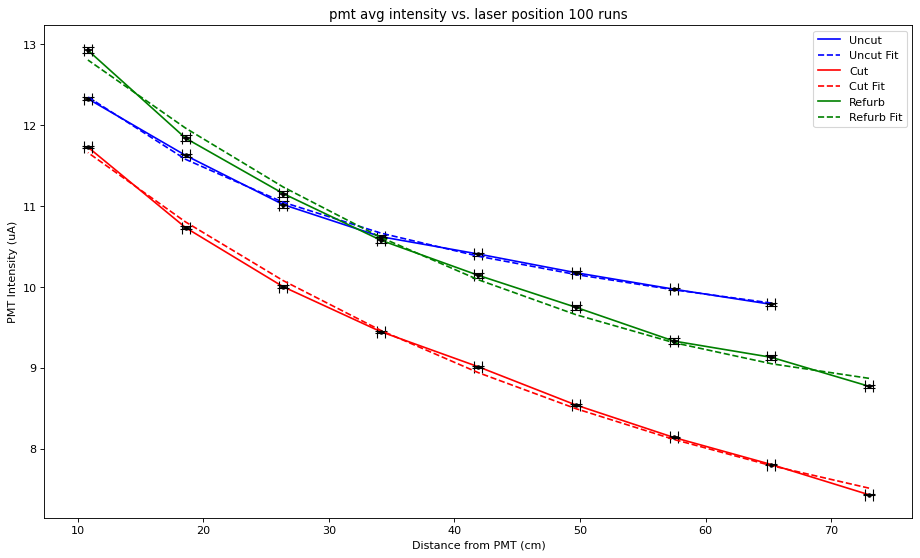

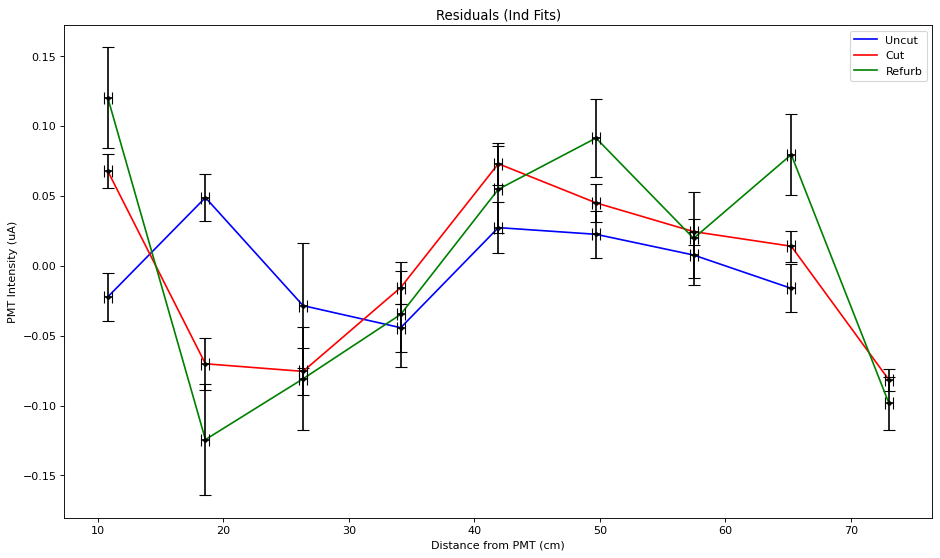

In [43]:
# Individual Fits (One Graph)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos2,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_fitp,color='b', linestyle='dashed')
# uncut error bars
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_fitp,color='r', linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_fitp,color='g', linestyle='dashed')
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals
fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos2,pmt_uncut_no_outliers_means-uncut_fitp,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_means-uncut_fitp, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_means-cut_fitp,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_fitp, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_fitp,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_fitp, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Residuals (Ind Fits)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Cut','Refurb'])
plt.show()

In [83]:
# Jointp

def joint_pchi2(a,A_L,A_S,R,P):
    lsP = []
    for i in range (26):
        lsP.append(P)
    data=np.concatenate([pmt_uncut_no_outliers_means,pmt_cut_no_outliers_means,pmt_ref_no_outliers_means])
    model=np.concatenate([det_uncut_no_outliers_means,det_cut_no_outliers_means,det_ref_no_outliers_means])*np.concatenate([Attenuation_w_Reflection(pos2,a,A_L,A_S,R,UncutL),Attenuation(pos,a,A_L,A_S),Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL)])+lsP
    err=np.concatenate([pmt_uncut_no_outliers_std,pmt_cut_no_outliers_std,pmt_ref_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)

In [99]:
pmt_uncut_no_outliers_means

[9.783269731958763,
 9.971100572916667,
 10.174138591836735,
 10.405276762886599,
 10.620145208333334,
 11.017109448979593,
 11.625639768421053,
 12.325949090909091]

In [94]:
# Joint Fit

Joint_Minp = Minuit(joint_pchi2, a=.73, A_L=350, A_S=20, R=0.1,P=0)
result1 = Joint_Minp.migrad()

# Print the result
print("Minimization result: Joint Fit (all three)")
print(result1)
cov_matrix_Joint=Joint_Minp.covariance
param_errors1=Joint_Minp.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors1, param_errors1)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Minp.values)
print("Parameters Errors:", Joint_Minp.errors)

Minimization result: Joint Fit (all three)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3620                       │             Nfcn = 1081              │
│ EDM = 11.3 (Goal: 0.0002)        │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─────────

In [95]:
uncut_Joint_all_fitp=det_uncut_no_outliers_means*Attenuation_w_Reflection(pos2,Joint_Minp.values['a'],Joint_Minp.values['A_L'],Joint_Minp.values['A_S'],Joint_Minp.values['R'],UncutL) + Joint_Minp.values['P']
cut_Joint_all_fitp=det_cut_no_outliers_means*Attenuation(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S']) + Joint_Minp.values['P']
ref_Joint_all_fitp=det_ref_no_outliers_means*Attenuation_w_Reflection(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'],Joint_Min.values['R'],RefurbL) + Joint_Minp.values['P']

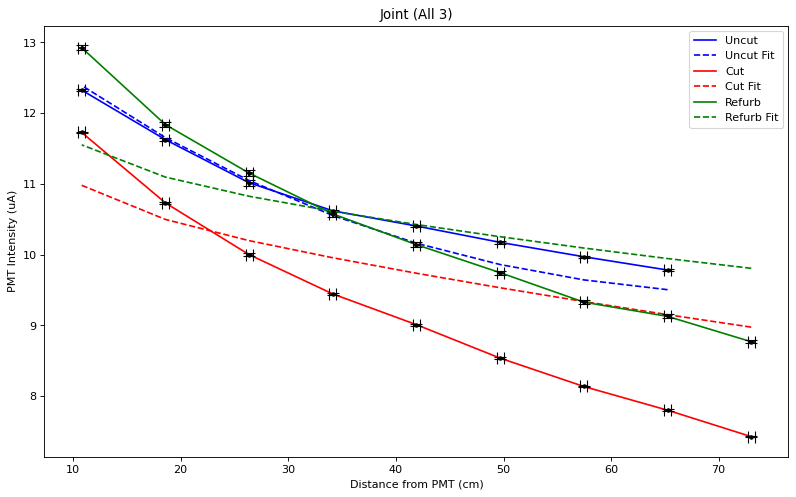

In [96]:
# Joint all 3 Fits (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos2,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos2,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos2,uncut_Joint_all_fitp,color='b',linestyle='dashed')
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_Joint_all_fitp,color='r',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_Joint_all_fitp,color='g',linestyle='dashed')
plt.title("Joint (All 3)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()